In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms, models
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from tqdm import tqdm
from sklearn.metrics import classification_report, accuracy_score, balanced_accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, auc, confusion_matrix
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import time
import random
import torch.optim as optim
import itertools

In [2]:
class BreastScanDataset(Dataset):
    def __init__(self, data, root_dir, transform=None, augmentations=None):
        self.data = data
        self.root_dir = root_dir
        self.transform = transform
        self.augmentations = augmentations
        self.label_map = {i: label for i, label in enumerate(data.columns[3:])}  # Create a mapping from class index to label

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path = self.root_dir+self.data.iloc[idx, 2][1:]
        image = Image.open(img_path).convert('RGB')  # Convert image to 'RGB'
        label_vector = self.data.iloc[idx, 3:]
        label_index = torch.argmax(torch.tensor(label_vector))  # Convert one-hot vector to class index

        if self.transform:
            image = self.transform(image)

        if self.augmentations and label_index in [1, 2, 3]:  # Check if augmentations should be applied
            # Randomly select one augmentation and apply it to the image
            aug = random.choice(self.augmentations)
            image = aug(image)

        return image, label_index

    def get_label(self, index):
        return self.label_map[index]

In [6]:
dataset_path ='/data/md311/Breast_Cancer_Detection_DBT/dataset/' 
df = pd.read_csv(dataset_path+'data_csv/train-v2_table_list_slice.csv')
# only work with a small portion of the dataset
df.drop(df.tail(16500).index, axis=0, inplace=True)
df

,StudyUID,view,img_path,Normal,Actionable,Benign,Cancer
0,DBT-S00163,rmlo,./images/train-v2/DBT-S00163_rmlo_16.png,0,0,1,0
1,DBT-S04378,lcc,./images/train-v2/DBT-S04378_lcc_31.png,0,1,0,0
2,DBT-S04378,lmlo,./images/train-v2/DBT-S04378_lmlo_33.png,0,1,0,0
3,DBT-S04378,rcc,./images/train-v2/DBT-S04378_rcc_29.png,0,1,0,0
4,DBT-S04378,rmlo,./images/train-v2/DBT-S04378_rmlo_31.png,0,1,0,0
...,...,...,...,...,...,...,...
392,DBT-S03835,rmlo,./images/train-v2/DBT-S03835_rmlo_24.png,1,0,0,0
393,DBT-S04911,lcc,./images/train-v2/DBT-S04911_lcc_34.png,0,1,0,0
394,DBT-S04911,lmlo,./images/train-v2/DBT-S04911_lmlo_37.png,0,1,0,0
395,DBT-S04911,rcc,./images/train-v2/DBT-S04911_rcc_31.png,0,1,0,0


In [9]:
# Define transformations
transform = transforms.Compose([
    transforms.Resize((224, 224), antialias=True),  # Resize images to fit ResNet input size
    transforms.ToTensor(),  # Convert PIL image to PyTorch tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize to ImageNet mean and std
])

# Create a new column indicating whether each study includes at least one image where 'Cancer' is 1
df['StudyHasCancer'] = df.groupby('StudyUID')['Cancer'].transform('max')

# Get the unique studies and their cancer status
unique_studies = df[['StudyUID', 'StudyHasCancer']].drop_duplicates()

# Split the studies using stratified sampling based on the 'StudyHasCancer' column
train_studies, test_studies = train_test_split(unique_studies, test_size=0.2, stratify=unique_studies['StudyHasCancer'], random_state=42)

# Get the training and test data
train_data = df[df['StudyUID'].isin(train_studies['StudyUID'])]
test_data = df[df['StudyUID'].isin(test_studies['StudyUID'])]

# Define the list of augmentations
augmentations_list = [
    transforms.RandomRotation(10),
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0), antialias=True),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.GaussianBlur(3, sigma=(0.1, 2.0))
]

# Number of random combinations to generate
n_augment = 12

# Generate n_augment random combinations of augmentations
random_combinations = []
for _ in range(n_augment):
    n_elements = random.randint(1, len(augmentations_list))  # Randomly choose the number of elements in the combination
    combination = random.sample(augmentations_list, n_elements)  # Randomly select elements
    random_combinations.append(combination)

# Create datasets
normal_train_data = train_data[(train_data['Normal'] == 1)]
augmented_train_data = train_data[(train_data['Actionable'] == 1) | (train_data['Benign'] == 1) | (train_data['Cancer'] == 1)]

# Create dataset for normal class
normal_train_dataset = BreastScanDataset(normal_train_data, dataset_path, transform)

# Create datasets for underrepresesnted without augmentation
original_train_dataset = BreastScanDataset(augmented_train_data, dataset_path, transform)

# Now, for each combination, create an augmented dataset and add it to the list of datasets
datasets = [normal_train_dataset, original_train_dataset]

for combination in random_combinations:
    augmented_dataset = BreastScanDataset(augmented_train_data, dataset_path, transform, combination)
    datasets.append(augmented_dataset)

# Concatenate all datasets
train_dataset = torch.utils.data.ConcatDataset(datasets)

test_dataset = BreastScanDataset(test_data, dataset_path, transform)

# Create data loaders
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [10]:
# Calculate the number of samples in each class before augmentation
original_class_counts = train_data.iloc[:, 3:-1].sum()
print("Class distribution before augmentation:")
print(original_class_counts)


print("\nClass distribution after augmentation:")
# Calculate the number of augmented samples
augmented_class_counts = augmented_train_data.iloc[:, 3:-1].sum() * n_augment

# Calculate the total number of samples in each class after augmentation
total_class_counts = original_class_counts + augmented_class_counts

print(total_class_counts)

Class distribution before augmentation:
Normal        212
Actionable     76
Benign         12
Cancer         12
dtype: int64

Class distribution after augmentation:
Normal        212
Actionable    304
Benign         48
Cancer         48
dtype: int64


In [11]:
# Define the function to load the pre-trained model and modify the final layer
def load_resnet50_model(num_classes, saved_weights_path=None):
    # Load the pretrained model
    model = models.resnet50(weights='DEFAULT')
    
    # Get the input of the fc layer
    num_ftrs = model.fc.in_features
    
    # Re-define the fc layer / classifier
    model.fc = nn.Linear(num_ftrs, num_classes)

    # Load the model weights from the saved file
    if saved_weights_path is not None:
        model.load_state_dict(torch.load(saved_weights_path))
    
    return model

def freeze_layers(model, n_layers_to_freeze):
    layers = list(model.children())[:n_layers_to_freeze]
    for layer in layers:
        for param in layer.parameters():
            param.requires_grad = False
    return model

def model_summary(model):
    print("Model Summary")
    print("-------------")
    total_layers = 0
    total_params = 0
    trainable_params = 0

    for name, layer in model.named_modules():
        total_layers += 1
        params = sum(p.numel() for p in layer.parameters())
        trainable = sum(p.numel() for p in layer.parameters() if p.requires_grad)
        total_params += params
        trainable_params += trainable
        print(f"{name}: {type(layer).__name__}, Params: {params}, Trainable: {trainable}")

    print("\nTotal Layers:", total_layers)
    print("Total Parameters:", total_params)
    print("Total Trainable Parameters:", trainable_params)

def get_loss_optimizer(model, learning_rate):
    # Define the loss function
    criterion = nn.CrossEntropyLoss()
    
    # Define the optimizer
    params_to_update = [param for param in model.parameters() if param.requires_grad]
    optimizer = torch.optim.Adam(params_to_update, lr=learning_rate)
    
    return criterion, optimizer

def train_model_cv(model, criterion, optimizer, dataset, train_loader, device, num_epochs, n_splits, save_path=None):
    model.to(device)
    
    # Initialize the KFold class
    kfold = KFold(n_splits=n_splits, shuffle=True)

    # Initialize lists to store the loss values
    train_losses = []
    val_losses = []
    epochs = []

    start_time = time.time()

    # Start the k-fold cross-validation
    for fold, (train_ids, val_ids) in enumerate(kfold.split(dataset)):
        # Print
        print(f'FOLD {fold}')
        print('--------------------------------')

        # Define the data loaders for training and validation
        train_subsampler = torch.utils.data.SubsetRandomSampler(train_ids)
        val_subsampler = torch.utils.data.SubsetRandomSampler(val_ids)
        train_loader = torch.utils.data.DataLoader(dataset, batch_size=32, sampler=train_subsampler)
        val_loader = torch.utils.data.DataLoader(dataset, batch_size=32, sampler=val_subsampler)

        # Train the model
        model.train()
        for epoch in range(num_epochs):
            running_loss = 0.0
            for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}, Training"):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Forward pass
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                # Backward pass and optimize
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                running_loss += loss.item() * inputs.size(0)

            epoch_loss = running_loss / len(train_loader.dataset)
            print(f'Train Loss: {epoch_loss:.4f}')
            train_losses.append(epoch_loss)
            epochs.append(epoch)

            # Validation
            model.eval()
            running_loss = 0.0
            all_preds = []
            all_labels = []
            with torch.no_grad():
                for inputs, labels in tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs}, Validation"):
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    running_loss += loss.item() * inputs.size(0)
                    all_preds.extend(preds.cpu().numpy())
                    all_labels.extend(labels.cpu().numpy())

            epoch_loss = running_loss / len(val_loader.dataset)
            print(f'Validation Loss: {epoch_loss:.4f}')
            val_losses.append(epoch_loss)
    
    end_time = time.time()
    print(f"\n______________________\nModel training complete.\nTotal training time: {end_time - start_time:.6f} seconds")

    if save_path is not None:
        torch.save(model.state_dict(), save_path)
        print("Weights saved to",save_path)
        
    # plot loss
    plot_loss(epochs, train_losses, val_losses)


# Define the function to evaluate the model
def evaluate_model(model, test_loader, test_dataset, device, num_classes):
    # Evaluate the model
    print("Evaluating Model...")
    model.eval()  # Set the model to evaluation mode
    
    all_preds = []
    all_labels = []
    all_probs = []
    with torch.no_grad():
        for images, labels in tqdm(test_loader, desc="Evaluating on test set..."):
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            probs = torch.nn.functional.softmax(outputs, dim=1)  # Get the predicted probabilities for all classes
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.append(probs.cpu().numpy())  # Append the probabilities as a 2D array

    all_probs = np.vstack(all_probs)  # Stack the probabilities

    # Calculate metrics
    accuracy = accuracy_score(all_labels, all_preds)
    balanced_accuracy = balanced_accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average='macro')
    recall = recall_score(all_labels, all_preds, average='macro')
    f1 = f1_score(all_labels, all_preds, average='macro')
    roc_auc = roc_auc_score(all_labels, all_probs, average='macro', multi_class='ovr')

    print(f"Accuracy: {accuracy:.2f}\nBalanced Accuracy: {balanced_accuracy:.2f}\nPrecision: {precision:.2f}\nRecall: {recall:.2f}\nF1: {f1:.2f}\nAUC: {roc_auc:.2f}")

    # Plot confusion matrix
    # unique_labels = [train_dataset.get_label(i) for i in np.sort(np.unique(all_labels))]
    unique_labels = [test_dataset.get_label(i) for i in np.sort(np.unique(all_labels))]

    classification_report(all_labels, all_preds)#, labels=unique_labels)


    plot_confusion_matrix(all_labels,all_preds,"Hey", unique_labels)

    # Plot ROC curve
    plot_roc_curve(np.eye(num_classes)[all_labels], all_probs, num_classes, unique_labels)

def plot_confusion_matrix(y_true, y_pred, task, unique_labels):
    
    plt.figure(figsize=(9,7),dpi=150)
    conf_mat = pd.DataFrame(confusion_matrix(y_true, y_pred), index=unique_labels, columns=unique_labels)
    print('\nConfusion Matrix:\n')
    print(conf_mat)
    sns.heatmap(conf_mat, annot=True, fmt='g', cmap='Blues', linewidth=.5, square=True)
    plt.ylabel('True Labels')
    plt.xlabel('Predicted Labels')
    plt.title("Confusion Matrix")
    plt.show()
    # plt.savefig('fig/confusion_matrix_'+task+'.png')

def plot_loss(epochs, train_losses, val_losses):
    
    plt.figure(figsize=(9,7),dpi=150)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Error Loss per Epoch")

    # Create a DataFrame from the lists
    loss_df = pd.DataFrame({
        'Epoch': epochs,
        'Training Loss': train_losses,
        'Validation Loss': val_losses
    })

    # Plot the training and validation loss
    sns.lineplot(data=loss_df, x='Epoch', y='Training Loss')
    sns.lineplot(data=loss_df, x='Epoch', y='Validation Loss')
    plt.show()
    # plt.savefig('fig/Training_Loss.png')

def plot_roc_curve(y_true, y_score, num_classes, class_labels):
    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(num_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Plot the ROC curve
    plt.figure(figsize=(9,7),dpi=150)
    for i in range(num_classes):
        plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})'.format(class_labels[i], roc_auc[i]))
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()


## Hyper-parameter Tuning

In [12]:
def hyperparameter_tuning(dataset, device, num_epochs, n_splits, num_trials):
    # Define the hyperparameters to tune
    learning_rates = [10**(-random.uniform(3, 5)) for _ in range(num_trials)]
    momentums = [random.uniform(0, 1) for _ in range(num_trials)]
    weight_decays = [10**(-random.uniform(3, 5)) for _ in range(num_trials)]
    batch_sizes = [2**i for i in range(4, 9)]
    dropout_rates = [random.uniform(0, 0.5) for _ in range(num_trials)]

    best_auc = 0
    best_params = {}

    start_time = time.time()

    # Perform random search
    for trial in range(num_trials):
        print(f'Trial {trial+1}/{num_trials}')
        print('--------------------------------')

        # Randomly select hyperparameters
        lr = random.choice(learning_rates)
        momentum = random.choice(momentums)
        weight_decay = random.choice(weight_decays)
        batch_size = random.choice(batch_sizes)
        dropout_rate = random.choice(dropout_rates)

        # Load the model
        model = load_resnet50_model(num_classes=4, freeze_params=True)
        model.to(device)

        # Define the loss function and the optimizer
        criterion, optimizer = get_loss_optimizer(model, learning_rate=lr)

        # Initialize the KFold class
        kfold = KFold(n_splits=n_splits, shuffle=True)

        # Start the k-fold cross-validation
        for fold, (train_ids, val_ids) in enumerate(kfold.split(dataset)):
            print(f'FOLD {fold}')
            # Define the data loaders for training and validation
            train_subsampler = torch.utils.data.SubsetRandomSampler(train_ids)
            val_subsampler = torch.utils.data.SubsetRandomSampler(val_ids)
            train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, sampler=train_subsampler)
            val_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, sampler=val_subsampler)

            # Train the model
            model.train()
            for epoch in range(num_epochs):
                for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}, Training"):
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    # Forward pass
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)

                    # Backward pass and optimize
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()

            # Validation
            model.eval()
            all_preds = []
            all_labels = []
            all_probs = []
            with torch.no_grad():
                for inputs, labels in tqdm(val_loader, desc="Validation"):
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    probs = torch.nn.functional.softmax(outputs, dim=1)  # Get the predicted probabilities for all classes
                    all_preds.extend(preds.cpu().numpy())
                    all_labels.extend(labels.cpu().numpy())
                    all_probs.append(probs.cpu().numpy())
            
            all_probs = np.vstack(all_probs)  # Stack the probabilities

            # Calculate AUC
            auc = roc_auc_score(all_labels, all_probs, average='macro', multi_class='ovr')

            # Update best AUC and best parameters
            if auc > best_auc:
                best_auc = auc
                best_params = {'learning_rate': lr, 'momentum': momentum, 'weight_decay': weight_decay, 'batch_size': batch_size, 'dropout_rate': dropout_rate}

    end_time = time.time()

    print(f"Hyperparameter tuning complete.\nTime taken: {end_time - start_time:.2f} seconds")
    print(f"Best AUC: {best_auc:.2f}")
    print(f"Best parameters: {best_params}")

    return best_params

In [13]:
num_classes = 4 
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [138]:
num_epochs = 1
n_splits = 2
n_iter = 3
num_trials = 1
hyperparameter_tuning(train_dataset, device, num_epochs, n_splits, num_trials)

Trial 1/1
--------------------------------


Validation: 100%|██████████████████████████████████████████████████████████████████████| 2/2 [00:36<00:00, 18.43s/it]

Hyperparameter tuning complete.
Time taken: 146.01 seconds
Best AUC: 0.52
Best parameters: {'learning_rate': 0.0008386346509827971, 'momentum': 0.031755431854909144, 'weight_decay': 0.00017708102868675967, 'batch_size': 256, 'dropout_rate': 0.06711838488312538}


{'learning_rate': 0.0008386346509827971,
 'momentum': 0.031755431854909144,
 'weight_decay': 0.00017708102868675967,
 'batch_size': 256,
 'dropout_rate': 0.06711838488312538}

In [14]:
learning_rate = 0.001 
num_epochs = 2
n_splits = 2

# load model
model = load_resnet50_model(num_classes)
model = freeze_layers(model, 8)
model_summary(model)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /home/md311/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|████████████████████████████████████████████████████████████████████| 97.8M/97.8M [00:01<00:00, 100MB/s]

Model Summary
-------------
: ResNet, Params: 23516228, Trainable: 8196
conv1: Conv2d, Params: 9408, Trainable: 0
bn1: BatchNorm2d, Params: 128, Trainable: 0
relu: ReLU, Params: 0, Trainable: 0
maxpool: MaxPool2d, Params: 0, Trainable: 0
layer1: Sequential, Params: 215808, Trainable: 0
layer1.0: Bottleneck, Params: 75008, Trainable: 0
layer1.0.conv1: Conv2d, Params: 4096, Trainable: 0
layer1.0.bn1: BatchNorm2d, Params: 128, Trainable: 0
layer1.0.conv2: Conv2d, Params: 36864, Trainable: 0
layer1.0.bn2: BatchNorm2d, Params: 128, Trainable: 0
layer1.0.conv3: Conv2d, Params: 16384, Trainable: 0
layer1.0.bn3: BatchNorm2d, Params: 512, Trainable: 0
layer1.0.relu: ReLU, Params: 0, Trainable: 0
layer1.0.downsample: Sequential, Params: 16896, Trainable: 0
layer1.0.downsample.0: Conv2d, Params: 16384, Trainable: 0
layer1.0.downsample.1: BatchNorm2d, Params: 512, Trainable: 0
layer1.1: Bottleneck, Params: 70400, Trainable: 0
layer1.1.conv1: Conv2d, Params: 16384, Trainable: 0
layer1.1.bn1: BatchN

## Train

FOLD 0
--------------------------------


Epoch 1/2, Training: 100%|███████████████████████████████████████████████████| 10/10 [00:34<00:00,  3.43s/it]


Train Loss: 0.5953


Epoch 1/2, Validation: 100%|█████████████████████████████████████████████████| 10/10 [00:33<00:00,  3.38s/it]


Validation Loss: 0.5741


Epoch 2/2, Training: 100%|███████████████████████████████████████████████████| 10/10 [00:31<00:00,  3.14s/it]


Train Loss: 0.5435


Epoch 2/2, Validation: 100%|█████████████████████████████████████████████████| 10/10 [00:31<00:00,  3.15s/it]


Validation Loss: 0.5709
FOLD 1
--------------------------------


Epoch 1/2, Training: 100%|███████████████████████████████████████████████████| 10/10 [00:31<00:00,  3.16s/it]


Train Loss: 0.5824


Epoch 1/2, Validation: 100%|█████████████████████████████████████████████████| 10/10 [00:31<00:00,  3.14s/it]


Validation Loss: 0.5396


Epoch 2/2, Training: 100%|███████████████████████████████████████████████████| 10/10 [00:31<00:00,  3.15s/it]


Train Loss: 0.5607


Epoch 2/2, Validation: 100%|█████████████████████████████████████████████████| 10/10 [00:31<00:00,  3.14s/it]


Validation Loss: 0.5357

______________________
Model training complete.
Total training time: 257.024952 seconds
Weights saved to /data/md311/Breast_Cancer_Detection_DBT/models/dbt_classification_resnet.pth


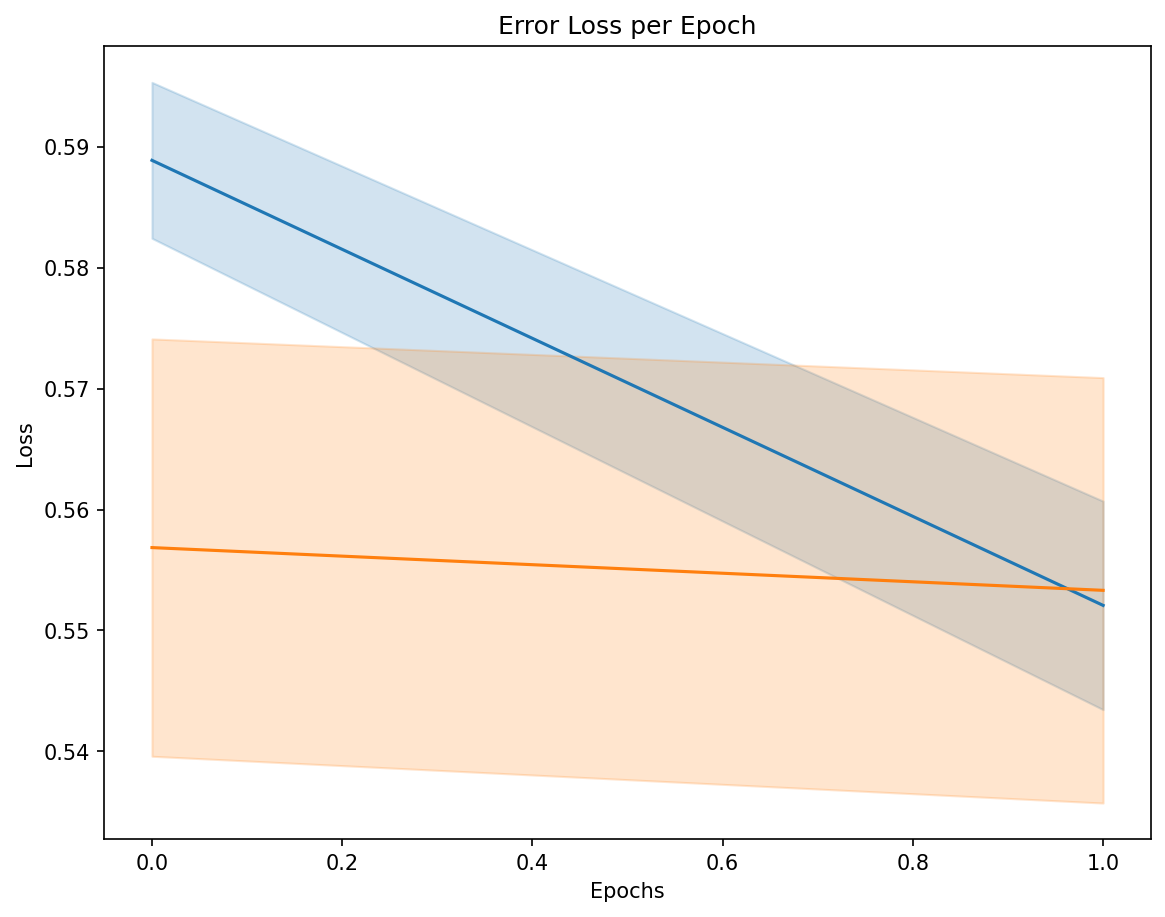

In [15]:
criterion, optimizer = get_loss_optimizer(model, learning_rate)
save_path = '/data/md311/Breast_Cancer_Detection_DBT/models/dbt_classification_resnet.pth'
train_model_cv(model, criterion, optimizer, train_dataset, train_loader, device, num_epochs, n_splits, save_path) 

## Evaluate

Evaluating Model...


Evaluating on test set...: 100%|███████████████████████████████████████████████| 2/2 [00:09<00:00,  4.56s/it]
/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modi

Accuracy: 0.28
Balanced Accuracy: 0.26
Precision: 0.27
Recall: 0.26
F1: 0.14
AUC: 0.45

Confusion Matrix:

            Normal  Actionable  Benign  Cancer
Normal           5          47       0       0
Actionable       1          19       0       0
Benign           0           7       0       0
Cancer           0           6       0       0


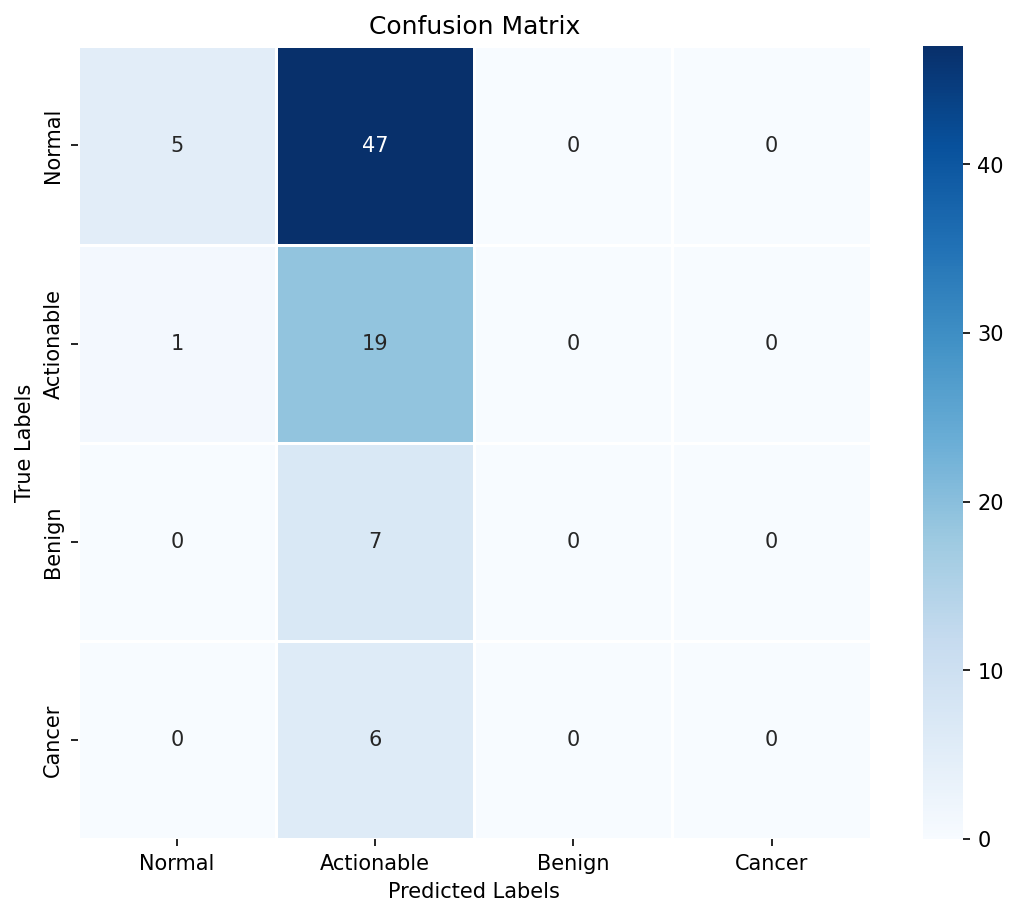

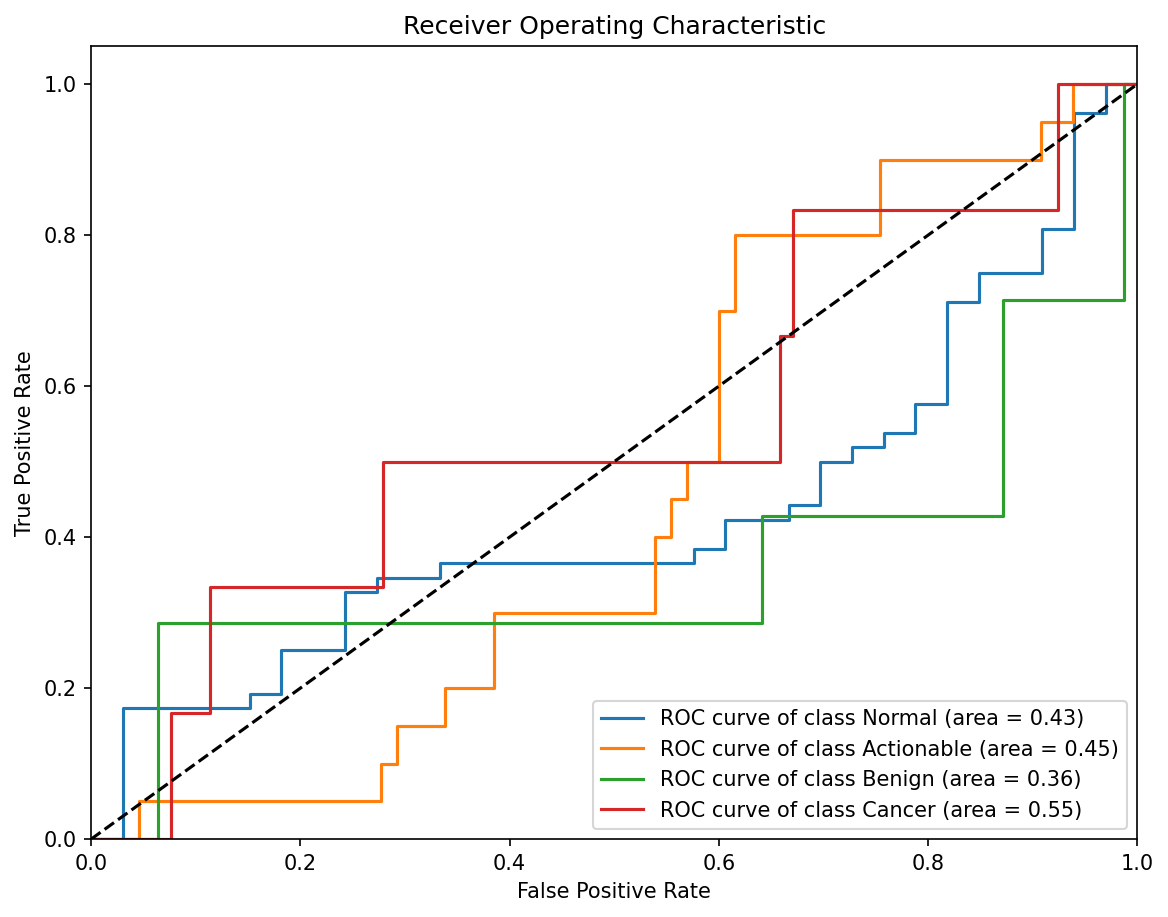

In [16]:
evaluate_model(model, test_loader, test_dataset, device, num_classes)

In [17]:
def predict_image(model, image_path, device, transform, class_labels):
    # Load and display the image
    image = Image.open(image_path)

    plt.figure(figsize=(5,5),dpi=150)
    plt.axis('off')
    plt.imshow(np.array(image), cmap='gray')
    plt.show()

    image = image.convert('RGB')

    # Apply the transformations to the image
    image = transform(image)

    # Add an extra batch dimension since pytorch treats all images as batches
    image = image.unsqueeze(0)

    # Move the input and model to GPU for speed if available
    image = image.to(device)
    model.to(device)

    # Set the model to evaluation mode
    model.eval()

    # Perform inference on the image
    start_time = time.time()
    with torch.no_grad():
        output = model(image)
        _, predicted = torch.max(output, 1)
        prob = torch.nn.functional.softmax(output, dim=1)[0] * 100
    end_time = time.time()

    # Print the class label and the corresponding probability
    print(f'The model predicts this image as a {class_labels[predicted]}, with a confidence of {prob[predicted].item():.2f}%.')

    print(f"Inference time: {end_time - start_time:.6f} seconds")

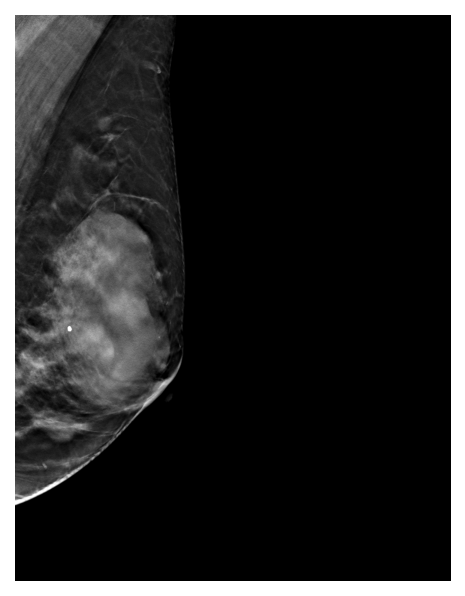

The model predicts this image as a Actionable, with a confidence of 44.65%.
Inference time: 0.053542 seconds


In [18]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')  # Use GPU if available, otherwise use CPU
class_labels = ['Normal', 'Actionable', 'Benign', 'Cancer']
model = load_resnet50_model(num_classes=4, saved_weights_path='/data/md311/Breast_Cancer_Detection_DBT/models/dbt_classification_resnet.pth')
img_path = '/data/md311/Breast_Cancer_Detection_DBT/dataset/images/train-v2/DBT-S00144_rmlo_29.png'
predict_image(model, img_path, device, transform, class_labels)
